#  Cool Circle Map

In [1]:
%matplotlib inline

from scipy import misc
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

First read in the image and show it.

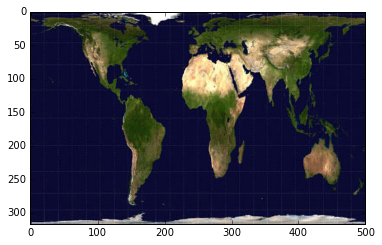

In [3]:
map1 = misc.imread('/Users/pfoley/map_projections/input_images/small_sat_peters.jpg')
plt.imshow(map1)

In [4]:
(ny, nx, _) = map1.shape
xs, ys = np.meshgrid(np.arange(0, nx), np.arange(0, ny))
xs = xs.flatten().astype(float)
ys = ys.flatten().astype(float)

print '`xs` has shape {} and range {}'.format(xs.shape,
                                             (np.amin(xs), np.amax(xs)))

print '`ys` has shape {} and range {}'.format(ys.shape,
                                             (np.amin(ys), np.amax(ys)))


`xs` has shape (158500,) and range (0.0, 499.0)
`ys` has shape (158500,) and range (0.0, 316.0)


In [5]:
mapdims = (nx, ny)
print 'mapdims are {}'.format(mapdims)

#  Pixel values are from 0 to N, so we need to do
#  some trickery to map them to (-pi,pi) and (-pi/2, pi/2)
def longitudeAndLatitudeFromGPPixel(x, y, mapdims):
    nx, ny = mapdims
    longitude = x * ( 2* np.pi / float(nx))  - np.pi
    latitude = np.arcsin(2.0 * ( (y / ny) - (0.5)) )
    return(longitude, latitude)

mapdims are (500, 317)


In [8]:
longitude, latitude = longitudeAndLatitudeFromGPPixel(xs, ys, mapdims)
print 'range of longitudes is {}'.format((np.amin(longitude), np.amax(longitude)))

range of longitudes is (-3.1415926535897931, 3.1290262829754347)


In [9]:
def spatialCoordinatesFromLongitudeAndLatitude(longitude, latitude):
    #longitude, latitude = longLat
    x = np.cos(longitude) * np.cos(latitude)
    y = np.sin(longitude) * np.cos(latitude)
    z = np.sin(latitude)
    return(x, y, z)

In [10]:
xxs, yys, zzs = spatialCoordinatesFromLongitudeAndLatitude(longitude, latitude)

##  Math Time

Now we have spatial locations $[x, y, z]^T$ for every pixel.  We need to choose a central location, and then make a transformation mapping things to radial coordinates.  Then we need something to find the closest pixel for every spot.

We need to pick three things:
  *  a center location $[x^*, y^*, z^*]$
  *  a second location $[x^r, y^r, z^r]$ that will define the orientation of the map.  That location will be directly to the right of the center, with an angle $\theta = 0$
  *  a radius $r$ to choose the limits of the map. 
  
We could also fix the location on the map of the second location, which would fix the radius.  But separetely choosing a radius allows for weirder maps that circumnavigate the globe more than once.  So we'll do that. 

The hardest part will probably be choosing a transformation.  This will require some math. 